In [1]:
import os

import numpy as np

from dynamic_programming.mdp_model import MDPModel
from envs.env_creator import env_creator
from base_algorithm.eval_policy import EvalDiscreteStatePolicy
import time
import pandas as pd
from rmin.train import RMinTrainer
from dynamic_programming.policy import DPPolicy
from envs.plot import plot_industrial_benchmark_trajectories
import seaborn as sns
from matplotlib import pyplot as plt

## Load Data and MDP Model

-342.73888027415506
10000000
0.0
1837


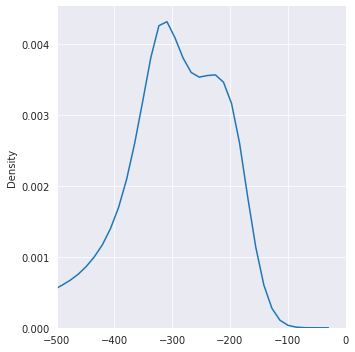

In [2]:


device = 'cpu'
load_path = os.path.join("tmp", "ibqf-out/ibq_samples.npy")
#load_path = os.path.join("tmp", "ibq_samples_50m.npy")
mdp_save_path = 'tmp/dynamic_programming/mdp_model.pkl'
sa_reward = True
samples = np.load(load_path, allow_pickle=True)[()]
sns.displot(samples['rewards'])
plt.xlim(-500, 0)
print(samples['rewards'].mean())
print(samples['rewards'].size)
samples['rewards'] = samples['rewards'] + np.abs(samples['rewards'].min())
print(samples['rewards'].min())
print(np.unique(samples['obs']).size)

## Compute MDP Model

In [3]:
start = time.time()
mdp_model = MDPModel(states=samples['obs'], next_states=samples['new_obs'], actions=samples['actions'],
                     rewards=samples['rewards'], dones=samples['dones'], device=device, sa_reward=sa_reward)

end = time.time()
print(end - start)

Computing Reward Function
Computing Transition Model
315.76353573799133


## Save MDP Model

In [4]:
mdp_model.save(mdp_save_path)

## Load MDP Model

In [3]:
mdp_model = MDPModel.load(mdp_save_path)

## Train

Epoch: 44


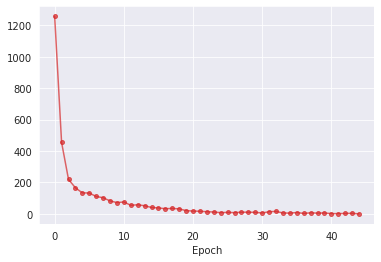

In [10]:

solver = RMinTrainer(reward_function=mdp_model.reward_function, transition_model=mdp_model.transition_model,
                     count_state_action=mdp_model.count_state_action, min_count=5)
solver.train(epochs=50000, gamma=0.99)
policy_save_path = 'tmp/rmin/ib_policy.pkl'

trained_policy = DPPolicy(policy_table=solver.get_policy(), state_to_index=mdp_model.state_to_index,
                          index_to_action=mdp_model.index_to_actions)
trained_policy.save(policy_save_path)

In [11]:
solver.get_policy()

array([17,  0,  8, ..., 25, 15, 26])

## Evaluate

In [12]:


steps_per_episode = 1000
env_kwargs = {'steps_per_episode': steps_per_episode,'device':device, 'model_path':'state_quantization/model'}

policy = DPPolicy.load(policy_save_path)
algo = EvalDiscreteStatePolicy(policy=policy, env_creator=env_creator, env_kwargs=env_kwargs)

Episode 9 Reward: -196.79066242849885 || New State Found: False


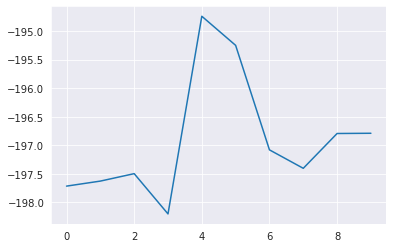

Reward Mean: -196.91087506647753
Reward std : 1.0458727537408832


In [13]:
algo.evaluate(epochs=10)

In [14]:
algo.eval_new_state_found

[False, False, False, False, False, False, False, False, False, False]

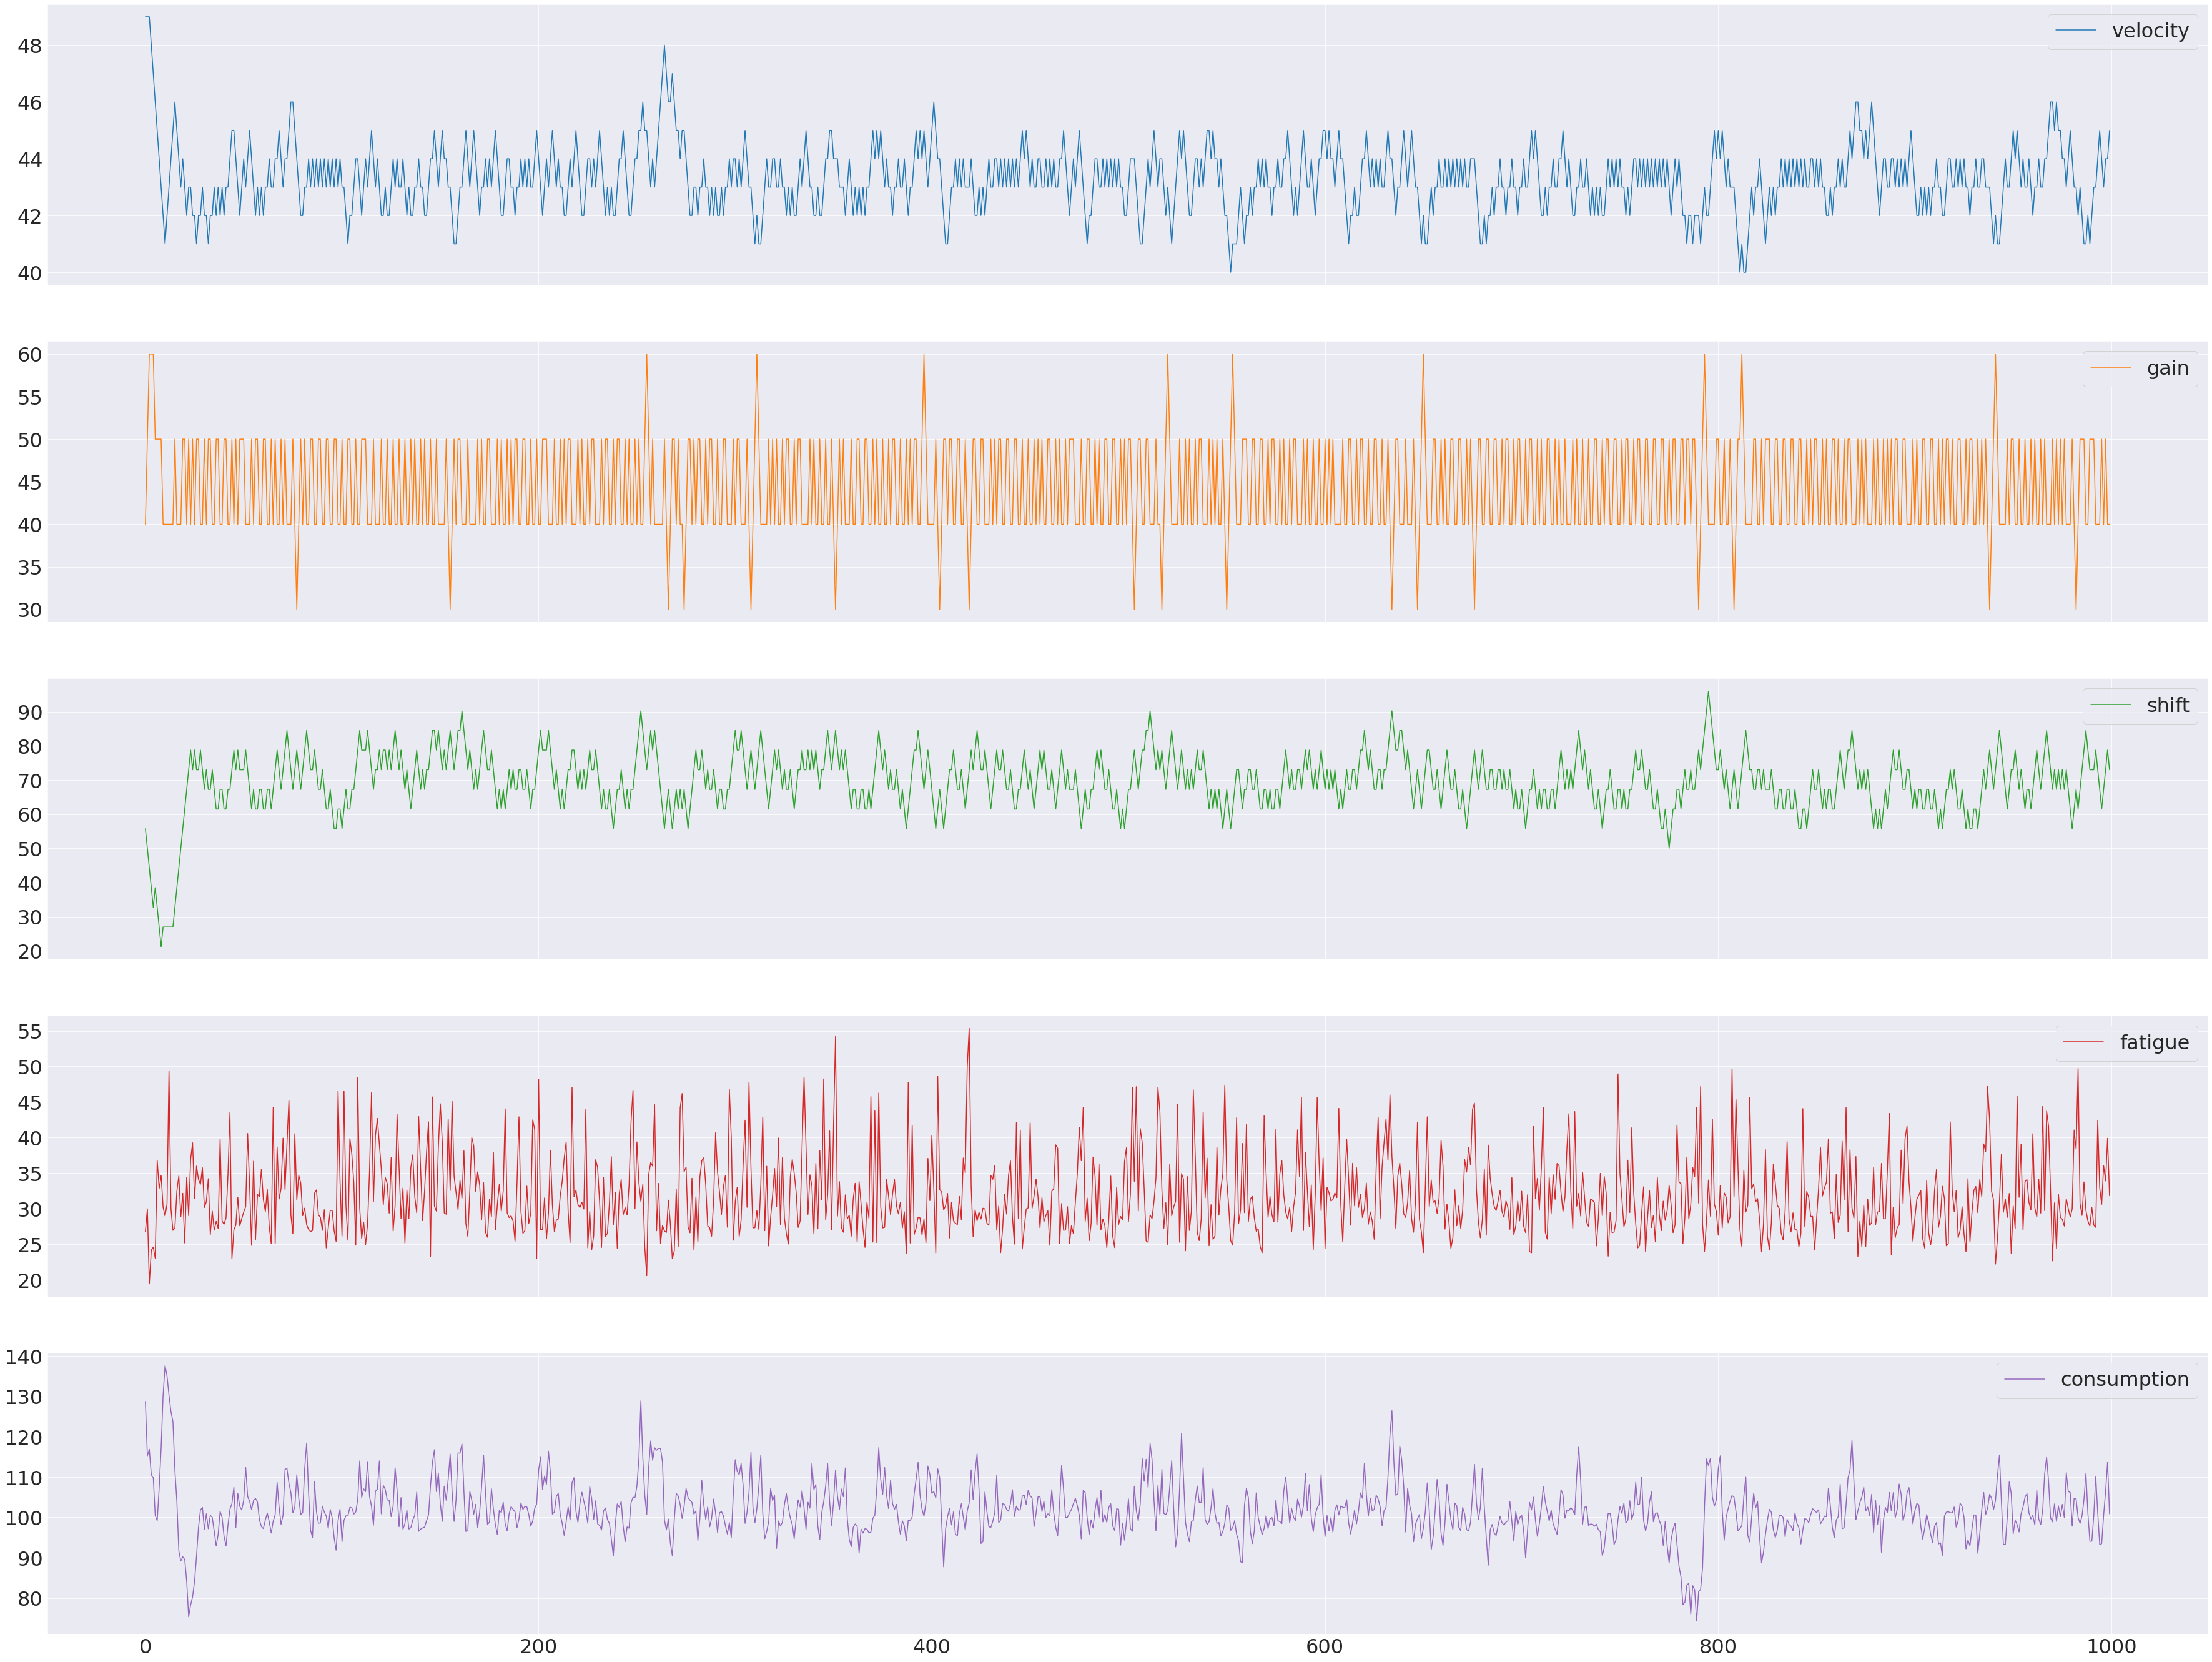

In [15]:
plot_industrial_benchmark_trajectories(algo.eval_trajectories[0]['info'])